In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os, sys, re, gc, glob
from tqdm.auto import tqdm, trange
from utils import JDIDataset, JDIModel, get_grey_image, assign_labels, DatasetBuilder, accuracy



import seaborn as sns

2021-05-18 16:47:30,680 -INFO - common:common.py:422 - Module utils.common is loaded...
2021-05-18 16:47:30,680 -INFO - dataset_builder:dataset_builder.py:16 - dataset package is loaded...
2021-05-18 16:47:30,687 -INFO - dataset:dataset.py:627 - dataset package is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
DEVICE='cpu'

In [4]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=2231, out_features=64, bias=False)
  (batchNorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=22, bias=True)
)

## Load test dataset

In [5]:
# dataset_name = 'angular'
# dataset_name = 'html-5'
# dataset_name = 'react-ant'
# dataset_name = 'mobile-and-html-5'
# dataset_name = 'bootstrap'
# dataset_name = 'dummy'
# dataset_name = 'google'
# dataset_name = 'cnews'
dataset_name = 'ac-avto161'

In [6]:
class TestDataset(DatasetBuilder):
    def setUp(self, driver):
        self.driver.set_window_size(width=1920, height=1090)
        super(TestDataset, self).setUp(driver=driver)
        

In [7]:
TestDataset(url='https://ac-avto161.ru/', dataset_name=dataset_name)
dataset_name = 'ac-avto161'

2021-05-18 16:47:33,274 -INFO - dataset_builder:dataset_builder.py:122 - Dataset name: ac-avto161
2021-05-18 16:47:33,274 -INFO - dataset_builder:dataset_builder.py:131 - Create directories to save the dataset
2021-05-18 16:47:33,279 -INFO - dataset_builder:dataset_builder.py:163 - Creating driver
2021-05-18 16:47:34,346 -INFO - dataset_builder:dataset_builder.py:171 - Chrome web driver is created
2021-05-18 16:47:34,471 -INFO - dataset_builder:dataset_builder.py:202 - getting url: https://ac-avto161.ru/
2021-05-18 16:47:40,741 -INFO - common:common.py:75 - Window maximized
2021-05-18 16:47:40,742 -INFO - dataset_builder:dataset_builder.py:174 - save scrinshot: dataset/images/ac-avto161.png
2021-05-18 16:47:42,027 -INFO - dataset_builder:dataset_builder.py:218 - Collect features using JS script
2021-05-18 16:47:42,621 -INFO - dataset_builder:dataset_builder.py:226 - Save html to dataset/html/ac-avto161.html
2021-05-18 16:47:42,641 -INFO - dataset_builder:dataset_builder.py:236 - Save p

In [8]:
dataset = JDIDataset(dataset_names=[dataset_name], rebalance=False)

2021-05-18 16:47:42,732 -INFO - dataset:dataset.py:235 - List of dataset_names:['ac-avto161']
2021-05-18 16:47:42,733 -INFO - dataset:dataset.py:241 - Dataset for ac-avto161
2021-05-18 16:47:44,831 -INFO - dataset:dataset.py:243 - Dataset shape: (794, 13)
2021-05-18 16:47:44,832 -INFO - dataset:dataset.py:245 - cleaning tag_name from dummy/auxiliary words
2021-05-18 16:47:44,833 -INFO - dataset:dataset.py:44 - select all leafs (nodes which are not parents)
2021-05-18 16:47:44,834 -INFO - dataset:dataset.py:47 - Leafs set size: 432 (nodes which have no children)
2021-05-18 16:47:44,835 -INFO - dataset:dataset.py:50 - count number of references to leafs
2021-05-18 16:47:44,837 -INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 224 (nodes which have leafs as children)
2021-05-18 16:47:44,839 -INFO - dataset:dataset.py:57 - count num children for each node
2021-05-18 16:47:44,840 -INFO - dataset:dataset.py:59 - Nodes with children: 363
2021-05-18 16:47:44,841 -INFO - da

  0%|          | 0/794 [00:00<?, ?it/s]

2021-05-18 16:47:46,245 -INFO - dataset:dataset.py:260 - Dataset shape after merging with parents: (794, 44)
2021-05-18 16:47:46,246 -WARNING - dataset:dataset.py:275 - assign dummy values [n/a] for labels if there is no annotations
2021-05-18 16:47:46,299 -INFO - dataset:dataset.py:282 - Concatenate datasets
2021-05-18 16:47:46,304 -INFO - dataset:dataset.py:284 - Dataset shape after reading: (794, 46)
2021-05-18 16:47:46,306 -WARNING - dataset:dataset.py:607 - Loading count vectorizer for column "cv_class": model/count_vectorizer_class.pkl
2021-05-18 16:47:46,310 -INFO - dataset:dataset.py:624 - class_sm: (794, 779)
2021-05-18 16:47:46,312 -INFO - dataset:dataset.py:293 - Build OHE column for attribute role
2021-05-18 16:47:46,314 -INFO - dataset:dataset.py:293 - Build OHE column for attribute type
2021-05-18 16:47:46,317 -INFO - dataset:dataset.py:293 - Build OHE column for attribute ui
2021-05-18 16:47:46,320 -INFO - dataset:dataset.py:298 - Build OHE column for attribute role_pare

In [9]:
dataset.dataset.shape

(794, 55)

In [10]:
dataset.labels

0      n/a
1      n/a
2      n/a
3      n/a
4      n/a
      ... 
789    n/a
790    n/a
791    n/a
792    n/a
793    n/a
Name: label, Length: 794, dtype: object

In [11]:
dataset.dataset.label

0      21
1      21
2      21
3      21
4      21
       ..
789    21
790    21
791    21
792    21
793    21
Name: label, Length: 794, dtype: int32

In [12]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, collate_fn=dataset.collate_fn, pin_memory=True)

In [13]:
results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            y_pred = y_pred[0].argmax()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/794 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label
0,21,21,n/a,n/a
1,21,21,n/a,n/a
2,21,21,n/a,n/a
3,21,21,n/a,n/a
4,21,21,n/a,n/a
...,...,...,...,...
789,21,21,n/a,n/a
790,21,21,n/a,n/a
791,21,21,n/a,n/a
792,21,21,n/a,n/a


In [14]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox_btn',
 'checkbox_label',
 'radiobutton_btn',
 'radiobutton_label',
 'textarea',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'table',
 'n/a']

In [15]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=results_df.y_true_label.values,
                     y_pred=results_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)



In [16]:
confusion_matrix_df

,button,link,iframe,textfield,dropdown,checkbox_btn,checkbox_label,radiobutton_btn,radiobutton_label,textarea,...,image,colorpicker,range,progressbar,datetimeselector,numberselector,dropdownselector,checklist,table,n/a
button,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
link,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textfield,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox_btn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox_label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton_btn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton_label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textarea,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
import seaborn as sns


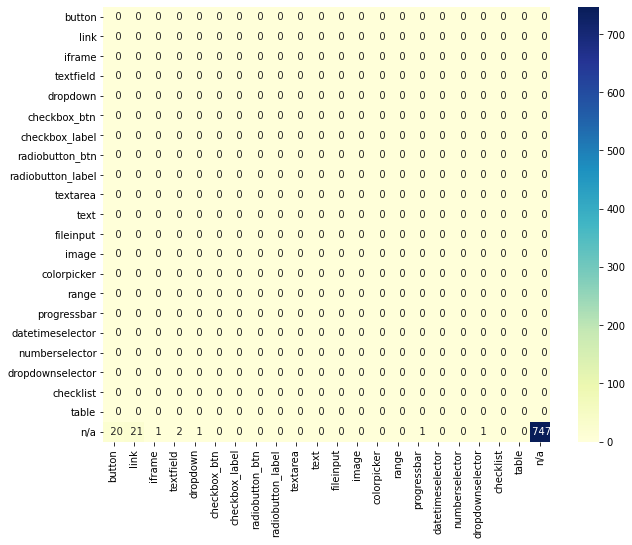

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu");

In [19]:
dataset_name

'ac-avto161'

In [20]:
accuracy(results_df)

2021-05-18 16:47:48,749 -INFO - common:common.py:457 - Accuracy:  0/47 = 0.0, for 794 elements


0.0

In [21]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'iframe': 2,
 'textfield': 3,
 'dropdown': 4,
 'checkbox_btn': 5,
 'checkbox_label': 6,
 'radiobutton_btn': 7,
 'radiobutton_label': 8,
 'textarea': 9,
 'text': 10,
 'fileinput': 11,
 'image': 12,
 'colorpicker': 13,
 'range': 14,
 'progressbar': 15,
 'datetimeselector': 16,
 'numberselector': 17,
 'dropdownselector': 18,
 'checklist': 19,
 'table': 20,
 'n/a': 21}

In [22]:

dataset.dataset['label_text_predicted'] = results_df.y_pred_label


(6221, 1903)


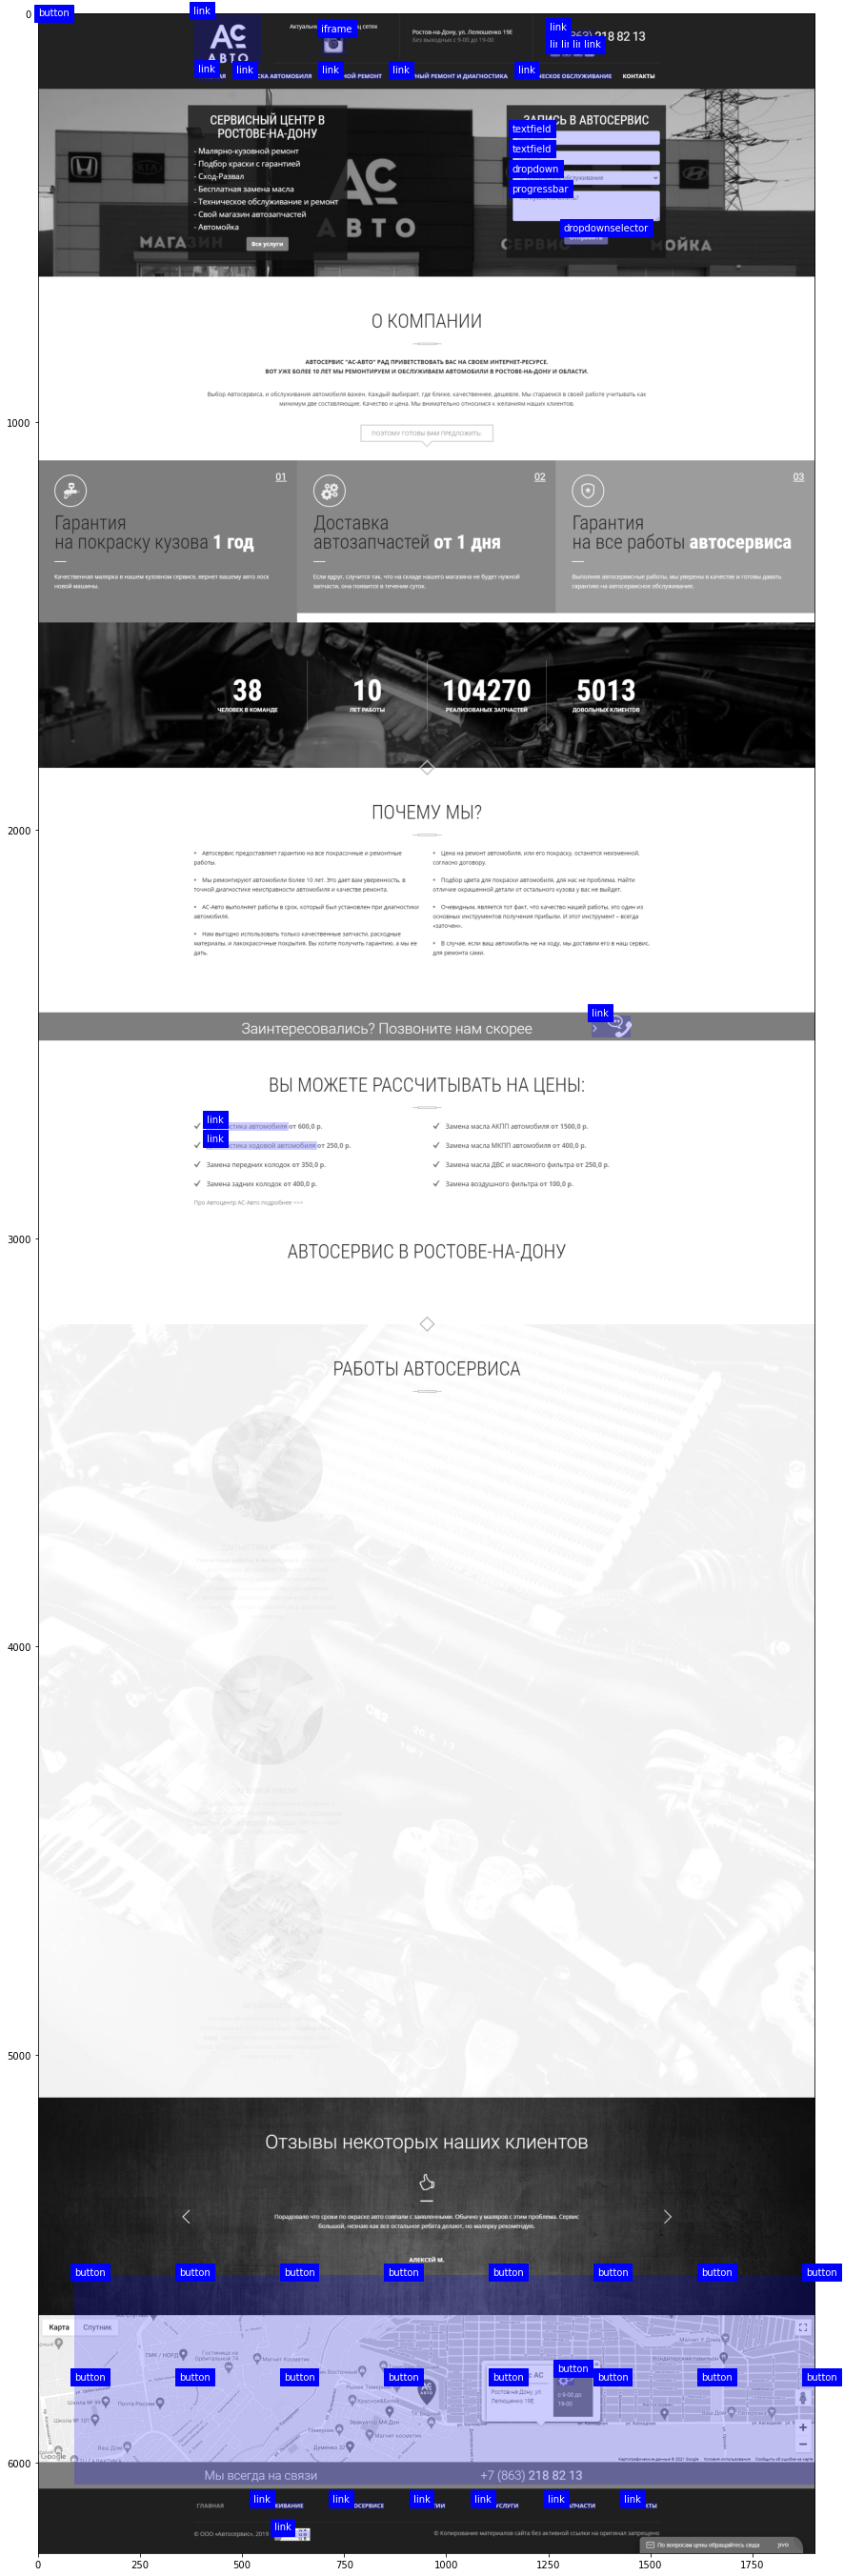

In [23]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset[dataset.dataset.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.dataset[dataset.dataset.label != dataset.dummy_class_value].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [24]:
results_df

,y_true,y_pred,y_true_label,y_pred_label
0,21,21,n/a,n/a
1,21,21,n/a,n/a
2,21,21,n/a,n/a
3,21,21,n/a,n/a
4,21,21,n/a,n/a
...,...,...,...,...
789,21,21,n/a,n/a
790,21,21,n/a,n/a
791,21,21,n/a,n/a
792,21,21,n/a,n/a


In [25]:
dataset.dataset[:1].to_json(orient='records')

'[{"attributes":{"action":null,"align":null,"allow":null,"alt":null,"aria-checked":null,"aria-current":null,"aria-expanded":null,"aria-hidden":null,"aria-label":null,"aria-labelledby":null,"aria-pressed":null,"aria-roledescription":null,"async":null,"charset":null,"class":" webkit chrome win js","content":null,"controlheight":null,"controlwidth":null,"data-cid":null,"data-lang":null,"data-parallax":null,"data-services":null,"defer":null,"dir":null,"draggable":null,"frameborder":null,"height":null,"href":null,"http-equiv":null,"id":null,"media":null,"method":null,"name":null,"onclick":null,"placeholder":null,"preload":null,"rel":null,"role":null,"rows":null,"sizes":null,"src":null,"style":null,"tabindex":null,"target":null,"title":null,"type":null,"value":null,"width":null},"displayed":true,"element_id":"4916793067456620283328625000","height":6221.0,"onmouseenter":null,"onmouseover":null,"parent_id":"4916793067456620283328625000","style":["align-content","align-items","align-self","alig